In [23]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.keras import metrics
from sklearn import datasets
import pandas as pd
import numpy as np
#import pandas_profiling as pp
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
%matplotlib inline

## Load and Clean Data

In [2]:
# Read in CSV
df = pd.read_csv("final_project.csv")
print(len(df))

160000


In [3]:
# Rename obvious columns
df.rename(columns={'x24': 'continent', 'x29': 'month', 'x30': 'day'}, inplace = True)
#list(df.columns) 

In [4]:
# initialize temp for x37 column
temp_x37 = []

# Remove $ ) , characters and replace '(' with '-' 
for i in range (0,len(df)) :
    try :
        n = df['x37'][i]
        nstr = re.sub(r'[$|,|)]',r'', n)
        nstr = re.sub(r'[(]',r'-',nstr)
        #nstr= float(nstr)
        temp_x37.append(nstr)
    except :
        nstr = ''
        temp_x37.append(nstr)

In [5]:
# Verify len of both x37 matches
print(len(df['x37']))
print(len(temp_x37))

# Replace 'x37' with new values and convert to numeric
df['x37'] = temp_x37
df["x37"] = pd.to_numeric(df["x37"])
df['x37']

160000
160000


0         1313.96
1         1962.78
2          430.47
3        -2366.29
4         -620.66
5         -196.45
6         -241.04
7          621.35
8         -301.89
9         -484.09
10        -106.65
11        -622.76
12         545.55
13        1019.08
14         960.95
15         299.52
16          72.83
17         -12.09
18        1074.27
19        -426.46
20        -710.18
21         370.01
22       -1199.52
23         -12.09
24        2158.38
25        -464.60
26        -526.08
27       -1321.42
28         771.15
29          41.97
           ...   
159970     954.38
159971     621.19
159972    1032.85
159973     729.11
159974    -167.10
159975     -33.14
159976    -409.63
159977    -126.15
159978     191.61
159979   -1356.91
159980     599.35
159981    -613.38
159982    2251.59
159983      -5.87
159984     198.30
159985   -1788.89
159986    -118.39
159987      15.62
159988     134.18
159989    -677.95
159990   -1012.45
159991   -1720.76
159992   -1177.33
159993    -818.32
159994    

In [7]:
# Correct misspellings and standardize values in labeled columns
df['continent'].replace('euorpe', 'europe',inplace=True)
df['month'].replace('Dev', '12',inplace=True)
df['month'].replace('Aug', '8',inplace=True)
df['month'].replace('Jun', '6',inplace=True)
df['month'].replace('Apr', '4',inplace=True)
df['month'].replace('Nov', '11',inplace=True)
df['month'].replace('sept.', '9',inplace=True)
df['month'].replace('Oct', '10',inplace=True)
df['month'].replace('Mar', '3',inplace=True)
df['month'].replace('January', '1',inplace=True)
df['month'].replace('Feb', '2',inplace=True)
df['month'].replace('May', '5',inplace=True)
df['month'].replace('July', '7',inplace=True)
df['month'].replace('December', '12',inplace=True)
df['month'].replace('August', '8',inplace=True)
df['month'].replace('June', '6',inplace=True)
df['month'].replace('April', '4',inplace=True)
df['month'].replace('November', '11',inplace=True)
df['month'].replace('September', '9',inplace=True)
df['month'].replace('October', '10',inplace=True)
df['month'].replace('March', '3',inplace=True)
df['day'].replace('thurday', 'thursday',inplace=True)



# check unique values in labeled columns
print (df['continent'].unique())
print (df['month'].unique())
print (df['day'].unique())

['europe' 'asia' 'america' nan]
['7' '8' '6' '5' '9' '4' '11' '10' nan '3' '2' '12' '1']
['tuesday' 'wednesday' 'thursday' 'monday' 'friday' nan]


In [8]:
#Remove % sign from x32
df['x32']=(df['x32'].str.rstrip('%').astype('float'))

In [9]:
# Testing with complete data set - Drop continent, x41, x6 per EDA suggestion.
# Need to drop day, month, x32 since it's categorical
knn_df = df.drop(['x41', 'x6', 'continent', 'day','x32'], axis=1)

#Fill NA with mean
knn_df=knn_df.fillna(df.mean())

#Drop any row with NA
knn_df=knn_df.dropna()

In [11]:
knn_df.head()

,x0,x1,x2,x3,x4,x5,x7,x8,x9,x10,...,x40,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,-14.789997,-1.040673,-4.204950,6.187465,...,-10.612200,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,-6.725709,0.896421,0.330165,-11.708859,...,2.147427,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,11.060572,5.325880,-2.632984,1.572647,...,-0.863137,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-18.913592,-0.337041,-5.568076,-2.000255,...,12.084421,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,27.532281,1.199715,-4.309105,6.667530,...,30.004727,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


<hr>
# KNN-dropNA-K=5
Created a dataset with the following changes

- dropped any rows with NA
- removed categorical features
- deleted x41 and x6 (per EDA suggestions)
## Accuracy = 79%

In [16]:
#Create x and y

x=knn_df.iloc[:,0:45].values
y=knn_df.iloc[:,-1].values

In [17]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [18]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

C:\Users\jodip\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
#Training and Predictions
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [20]:
y_pred=classifier.predict(x_test)

In [25]:
#Evaluating Results
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[16495  2801]
 [ 3792  8906]]
             precision    recall  f1-score   support

          0       0.81      0.85      0.83     19296
          1       0.76      0.70      0.73     12698

avg / total       0.79      0.79      0.79     31994



<hr>
# KNN Loop K=1-25 to find best K value
Created a dataset with the following changes

- dropped any rows with NA
- removed categorical features
- deleted x41 and x6 (per EDA suggestions)
- removed features that had a random forest importance < 0.04
## Best value - K=7

In [26]:
knn_importance_df = knn_df[['x23', 'x20', 'x48', 'x49', 'x38', 'x12', 'x42', 'x27','x40', 'x37','x28','x7','x2', 'x46', 'y']]

In [35]:
#Create x and y

x=knn_importance_df.iloc[:,0:14].values
y=knn_importance_df.iloc[:,-1].values

In [39]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [40]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [42]:
#source: https://www.ritchieng.com/machine-learning-k-nearest-neighbors-knn/
# try K=1 through K=25 and record testing accuracy
k_range = range(1, 26)

# We can create Python dictionary using [] or dict()
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

print(scores)

[0.9320185034694005, 0.9298305932362317, 0.946458711008314, 0.9445208476589361, 0.9494905294742765, 0.9484278302181659, 0.9500843908232793, 0.9490216915671689, 0.949771832218541, 0.9485215977995874, 0.9488966681252735, 0.948615365381009, 0.9492404825904858, 0.9488966681252735, 0.9488654122647997, 0.948209039194849, 0.9487716446833782, 0.9483653184972183, 0.9484903419391136, 0.9478652247296369, 0.9479277364505845, 0.9473963868225292, 0.9474588985434769, 0.9470213164968432, 0.9471775957992123]


Text(0, 0.5, 'Accuracy')

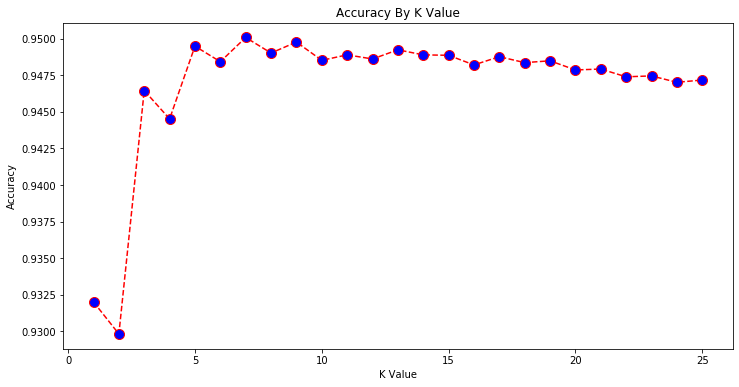

In [44]:
#Visualize it 
# Source: https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

plt.figure(figsize=(12, 6))
plt.plot(range(1, 26), scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy By K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')

<hr> 
# KNN-K=7
Ran model with K=7 per findings from loop above
## Accuracy = 94.93%

In [45]:
#Create x and y

x=knn_importance_df.iloc[:,0:14].values
y=knn_importance_df.iloc[:,-1].values

In [46]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [47]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [48]:
#Training and Predictions
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [49]:
y_pred=classifier.predict(x_test)

In [50]:
#Evaluating Results
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9493655060323811
[[18421   781]
 [  839 11953]]
             precision    recall  f1-score   support

          0       0.96      0.96      0.96     19202
          1       0.94      0.93      0.94     12792

avg / total       0.95      0.95      0.95     31994



# YAY!!  Accuracy = 95%